<a href="https://colab.research.google.com/github/VladimirFilipovic/pppo/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importujemo potrebne biblioteke
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np 
import pandas as pd 

from IPython.display import display, Image

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

## Sadržaj

1. Uvod
2. Opis podataka
4. Proces treniranja i izabrani prilaz 
5. Obučavanje klasifikacionog modela
5. Zaključak
6. Literatura



###**Uvod**

Klasifikacija fotografija predstavlja nadgledani zadatak mašinskog učenja,
koji se odnosi na proces dodeljivanja oznake ulaznoj fotografiji iz skupa oznaka (klasa) na osnovu odredjenih atributa.
Postoje četiri osnovne vrste klasifikacije:

*   **Binary classification**- zadaci klasifikacije kod kojih se skup mogucih klasa sastoji od dve klase
*   **Multi-class classification** - zadaci klasifikacije u kojima postoji više mogućih klasa 
*   **Multi-label classification** - zadaci klasifikacije u kojima postoji više klasa od kojih jedna ili više njih mogu da budu dodeljeni instanci
*   **Imbalanced classificaton** - odnosi se na klasifikacione zadatke nad setom podataka u kom vecina instanci pripadaju malom podskupu svih klasa

Odradjeni zadatak se sastoji iz odredjivanja rase pasa na osnovu zadatih slika.

###**Opis podataka**
Set podataka se sastoji od ~10000 slika koje trebaju biti svrstane u jednu od 120 mogucih klasa.

Fajl labels.csv sadrzi dve kolone jedna predstavlja naziv slike a druga rasu pasa kojoj pas sa te slike pripada.

In [ ]:
#generalne informacije o klasama
labels = pd.read_csv('/content/drive/MyDrive/PPPO/labels.csv')
labels.head()
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,51c0c9e80619fed2bd743867c1a1b0b0,scottish_deerhound
freq,1,126


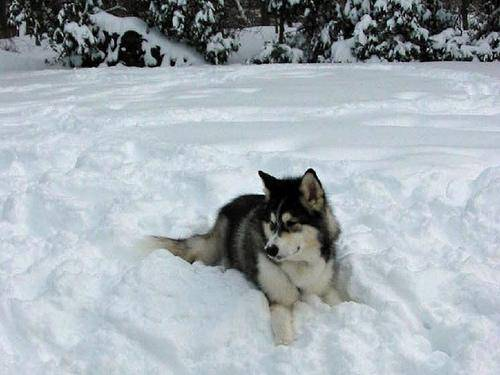

In [ ]:
#primer jedne slike iz seta podataka
Image("../content/drive/MyDrive/PPPO/train/185dd9ac0589562442f553cf686783d4.jpg")

###**Proces treniranja i izabrani prilaz**
Konvoluciona neuralna mreza je jedan on modela masinskog ucenja za klasifikaciju slika, ali u ovom slucaju, nemamo dovoljno slika da je na adekvatan nacin istreniramo. Najverovatniji scenario jeste da ce model overfit-vati trening set i njegova preciznost na testnom setu ce biti niska.
Stoga ce u zadataku biti koriscen prilaz poznat kao *transfer learning*

Transfer learning podrazumeva preuzimanje prethodno istreniraniranih modela i njihovu primenu nad novim setom podataka. U izradi ovog zadatka su korisceni:


*   **InceptionV3**
*   **InceptionResNetV2**

###**Predprocesuiranje podataka**
Podatke je pre koriscenja potrebno kodirati na nacin koji zahteva model koji se korsiti. U ovom slucaju je izvrsen *One Hot Encoding* gde je svaka fotografija  preslikana u binarni vektor.




In [ ]:
#kreiramo listu klasa
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Ukuno razlicitih rasa {}'.format(n_classes))

class_to_num = dict(zip(classes, range(n_classes)))
class_to_num


#kreiramo niz  
input_shape = (331,331,3)
def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) 
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix]=img
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

Ukuno razlicitih rasa 120


In [ ]:
import time 
t = time.time()

X,y = images_to_array('/content/drive/MyDrive/PPPO/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 3108.5255613327026


In [ ]:
print(X)

#####**Optimizacija hiperparametara i optimizacioni algoritmi**


Performanse modela značajno mogu da budu poboljšane za različite vrednosti parametara modela. Ovi parametri se nazivaju hiperparametri, jer predstavljaju parametre modela koji se ne uče, već se određuju prilikom izgradnje modela pre same faze treniranja (C, kernel, gamma).

Optimizacija hiperparametara je problem odabira optimalnih vrednosti hiperparametara modela. Vrednosti ovih parametara kontrolišu učenje modela i potrebno je podesiti ih kako bi model optimalno rešavao postavljen zadatak.

Korisceni optimizacioni algoritmi su:

*   **Adam** - Najkorisceniji algoritam za obucavanje neuronskih mreza (eng. adaptive moment estimation). Zasniva se na ocenama prvog i drugog momenta
gradijenata
*   **SGD**



In [ ]:
#ukoliko se preciznost modela ne povecava smanjujemo learning rate za .01
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#ukoliko se model ne poboljsava prekidamo treniranje
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#cuvamo najbolji model 
checkpointer=ModelCheckpoint(filepath='model1.hdf5',verbose=1,save_best_only=True)

#hiperparametri
batch_size= 128
epochs=20
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#funkcija za ekstrahovanje feature-a iz data seta sa prosledjenim modelom
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):
 
    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #ekstrahovanje feature-a
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Oblik feature-a: ', feature_maps.shape)
    return feature_maps

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

320/320 [==============================] - 2251s 7s/step
Feature maps shape:  (10222, 2048)


In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

320/320 [==============================] - 5317s 17s/step
Feature maps shape:  (10222, 1536)


In [ ]:

gc.collect()
3584
#Kreiranje finalnog feature vektora kombinovanjem prethodno ekstraktovanih feature-a

final_features = np.concatenate([inception_features,
                                 inc_resnet_features,], axis=-1) 

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 3584)


#####**Trening modela**

Prilikom obučavanja modela, definiše se broj epoha, pri čemu epoha predstavlja prolazak preko celokupnog skupa trening podataka. Epoha se sastoji iz iteracija, gde broj iteracija zavisi od veličine batch-a (broj uzoraka po ažuriranju gradijenta). Nakon svake iteracije i prolaska kroz određeni broj podataka (određen veličinom batch-a), na osnovu sračunate funkcije gubitka se vrše podešavanja parametara i zatim uz pomoć validacionih podataka računa tačnost modela.

In [ ]:
model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Treniranje modela 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop,checkpointer])

Epoch 1/20
64/64 [==============================] - 2s 17ms/step - loss: 1.9018 - accuracy: 0.6630 - val_loss: 0.3642 - val_accuracy: 0.9203

Epoch 00001: val_loss improved from inf to 0.36415, saving model to model1.hdf5
Epoch 2/20
64/64 [==============================] - 1s 14ms/step - loss: 0.3331 - accuracy: 0.9162 - val_loss: 0.2508 - val_accuracy: 0.9281

Epoch 00002: val_loss improved from 0.36415 to 0.25081, saving model to model1.hdf5
Epoch 3/20
64/64 [==============================] - 1s 14ms/step - loss: 0.2518 - accuracy: 0.9266 - val_loss: 0.2214 - val_accuracy: 0.9296

Epoch 00003: val_loss improved from 0.25081 to 0.22145, saving model to model1.hdf5
Epoch 4/20
64/64 [==============================] - 1s 14ms/step - loss: 0.2089 - accuracy: 0.9374 - val_loss: 0.2131 - val_accuracy: 0.9330

Epoch 00004: val_loss improved from 0.22145 to 0.21314, saving model to model1.hdf5
Epoch 5/20
64/64 [==============================] - 1s 14ms/step - loss: 0.1884 - accuracy: 0.9417 -

###**Zaključak**

Zadatak klasifikacije pasa na osnovu slika rešen je procesom transfer learninga-a. Ekstraktovani su feature-i InceptionResNetV2 i InceptionV3 modela, i zatim je izvresena konkatenacija njihovih featura kako bi se dobio konacan model.

Klasifikator je postigao zadovoljavajucu tacnost predikcije od 97%.  

Modeli se dalje mogu unaprediti koriscenjem K-fold unakrsne validacije koja bi doprinela boljoj evaluaciji modela kao i augmentovanjem seta podataka kako bi model uvecali skup podataka za trening.

In [ ]:
###**Literatura**

Ćulibrk, D. (2012). *Otkrivanje znanja iz podataka: Odabrana poglavlja*. Fort Lauderdale, USA: CreateSpace Independent Publishing Platform. 

Goodfellow, I. & Bengio Y. & CourvilleClark A. (2016).*Deep Learning*. An MIT Press book. https://doi.https://www.deeplearningbook.org/

Stanford University School of Engineering. (2017, August 11). *Lecture 4|Introduction to Neural Networks* [Video]. https://www.youtube.com/watch?v=d14TUNcbn1k

Singh, S. (2021, May 21). Adam — latest trends in deep learning optimization. Retrieved from https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

# New Section